# 

# IML assignment 1
## Nabiullin Damir 
## d.nabiullin@innopolis.university

# Import numpy, pandas, and matplotlib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline 

# Read given data set

In [2]:
# Read data set
data = pd.read_csv('a1_dataset.csv')
print(data.shape)
data.head()

(925, 8)


,target,var1,var2,var3,var4,var5,var6,var7
0,0,509.18,417.681,Micronesia,138.0,393.00,no,2019-07-20 13:21:37
1,0,446.06,666.182,Dominica,81.0,352.05,yes,2019-04-04 21:30:46
2,1,235.50,398.097,Isle of Man,90.0,339.00,no,2019-03-03 02:59:37
3,0,306.02,518.163,Turkmenistan,102.0,439.25,yes,2019-03-19 08:00:58
4,0,453.08,600.156,Cameroon,105.0,422.95,no,2019-03-18 13:22:35


# Preprocessing

## Prepare *var7*

In [3]:
# Function to convert date to seconds
def date_to_seconds(date_time: str):
    date, time = date_time.split()
    year, month, day = map(int, date.split('-'))
    hour, minute, second = map(int, time.split(':'))
    time = (hour * 3600) + (minute * 60) + second
    date = (year * 31556926) + (month * 2629743) + (day * 86400)
    return date + time - 62169920446 # time from 1970-01-01

# Convert data in column var7 to seconds
data['var7'] = data['var7'].apply(date_to_seconds)

## Encoding

### Prepare features for encoding

In [4]:
# Prepare features for encoding
features_name = ['var3', 'var6', 'var7']
# len(pd.unique(data['var3']))

### Ordinal Encoding

I decided to use Ordinal encoding for *var3*, *va6*, and *var7*.

In [5]:
from sklearn.preprocessing import OrdinalEncoder

# Create encoder
encoder = OrdinalEncoder()

# Create new data frame
new_feats = encoder.fit_transform(data[features_name])
new_cols = pd.DataFrame(new_feats, dtype=int, columns=features_name)
new_data = data.drop(features_name, axis=1)
new_data = pd.concat([new_data, new_cols], axis=1)
new_data


,target,var1,var2,var4,var5,var3,var6,var7
0,0,509.18,417.681,138.0,393.00,137,0,907
1,0,446.06,666.182,81.0,352.05,57,1,438
2,1,235.50,398.097,90.0,339.00,101,0,285
3,0,306.02,518.163,102.0,439.25,216,1,361
4,0,453.08,600.156,105.0,422.95,36,0,357
...,...,...,...,...,...,...,...,...
920,0,422.34,547.259,NaN,350.45,19,1,93
921,1,342.62,473.919,NaN,200.85,105,0,138
922,1,265.10,538.170,NaN,208.35,179,1,752
923,0,397.12,622.386,NaN,433.45,41,1,669


## Data Imputation

### Prepare data for predicting *var4*

In [6]:
# Split data on nan and not nan
data_var4 = new_data[new_data['var4'].notna()]
predict_data_var4 = new_data[new_data['var4'].isna()]

# Print shapes of datas
print('Testing:', predict_data_var4.shape, 'Training:', data_var4.shape)

Testing: (600, 8) Training: (325, 8)


In [7]:
from sklearn.model_selection import train_test_split

# Creata X_predict on which we will predict var4
X_predict = pd.concat([predict_data_var4.loc[:, :'var2'], 
                       predict_data_var4.loc[:, 'var5':]], 
                       axis=1)

# Split data for training and testing
X = pd.concat([data_var4.loc[:, :'var2'], 
               data_var4.loc[:, 'var5':]], 
               axis=1)
y = data_var4['var4']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Linear regression

In [8]:
from sklearn.linear_model import LinearRegression

# Create Linerar Regressor
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predict values
y_pred = regressor.predict(X_test)

#### Errors

In [9]:
from sklearn import metrics

# Print errors
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 16.764254134687054
Mean Squared Error: 462.4199068342634
Root Mean Squared Error: 21.503950958702063


### Polynomial regression

In [10]:
# Create list of degrees to try
degrees = [i for i in range(2, 10)]

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# Create lists to store errors
mae_to_plot = []
mse_to_plot = []
rmse_to_plot = []

# Try polynomial regression on different degrees
for i in degrees:
    polynomial_features = PolynomialFeatures(degree=i)
    linear_regression = LinearRegression()
    regressor = Pipeline([("polynomial_features", polynomial_features),
                          ("linear_regression", linear_regression)])
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    mae_to_plot.append(metrics.mean_absolute_error(y_test, y_pred))
    mse_to_plot.append(metrics.mean_squared_error(y_test, y_pred))
    rmse_to_plot.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

#### Errors

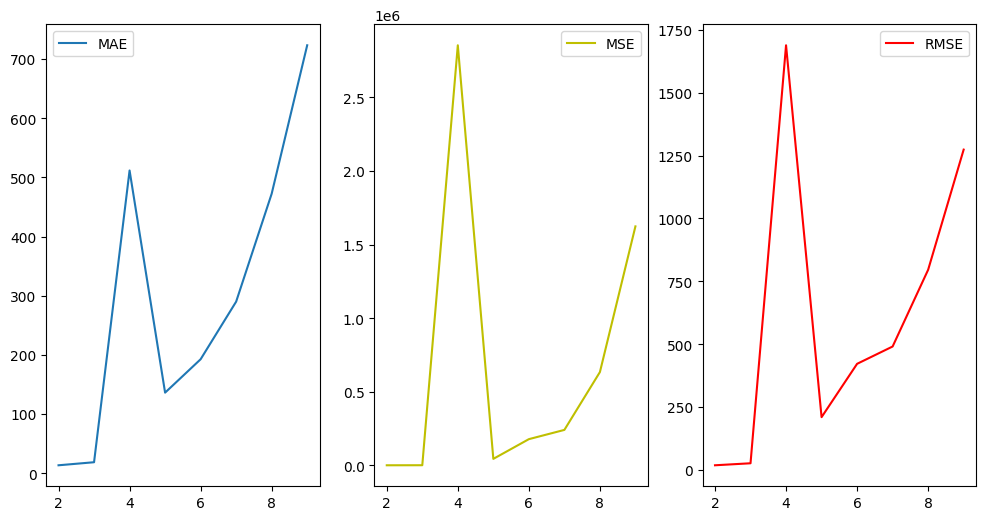

MAE [13.539651550753758, 18.68363807692121, 511.5711680151672, 136.2531273573815, 192.67208509675578, 289.99843318022545, 472.2936013511053, 723.1111090658986]
MSE [321.39898965208164, 671.0738258867681, 2853773.4583606916, 43867.316637029646, 177793.24568530612, 240665.44401230646, 633525.434021158, 1623367.5167906198]
RMSE [17.92760412470338, 25.905092663157337, 1689.3115338387681, 209.44525928516416, 421.6553636387258, 490.57664438118786, 795.9431097893605, 1274.1144049066472]


In [12]:
# Split plot
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

# Plot data
ax1.plot(degrees, mae_to_plot, label='MAE')
ax2.plot(degrees, mse_to_plot, label='MSE', c='y')
ax3.plot(degrees, rmse_to_plot, label='RMSE', c='r')

# Show plots
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

# Print values of errors
print('MAE', mae_to_plot)
print('MSE', mse_to_plot)
print('RMSE', rmse_to_plot)

### Find the missing values of *var4*

According to errors, it is better to use polynomial regression of the second degree to predict *var4*

In [13]:
# Prepare polynomial regression
polynomial_features = PolynomialFeatures(degree=2)
regressor = Pipeline([("polynomial_features", polynomial_features),
                      ("linear_regression", linear_regression)])
regressor.fit(X, y)

# Predict values
y_predict = regressor.predict(X_predict)

# Create new data frame
X['var4'] = y
X_predict['var4'] = y_predict

preprocessed_data = pd.concat([X, X_predict], axis=0)
preprocessed_data

,target,var1,var2,var5,var3,var6,var7,var4
0,0,509.18,417.681,393.00,137,0,907,138.000000
1,0,446.06,666.182,352.05,57,1,438,81.000000
2,1,235.50,398.097,339.00,101,0,285,90.000000
3,0,306.02,518.163,439.25,216,1,361,102.000000
4,0,453.08,600.156,422.95,36,0,357,105.000000
...,...,...,...,...,...,...,...,...
920,0,422.34,547.259,350.45,19,1,93,89.595743
921,1,342.62,473.919,200.85,105,0,138,120.225075
922,1,265.10,538.170,208.35,179,1,752,118.377139
923,0,397.12,622.386,433.45,41,1,669,111.133209


### Check Spearman’s correlation of features

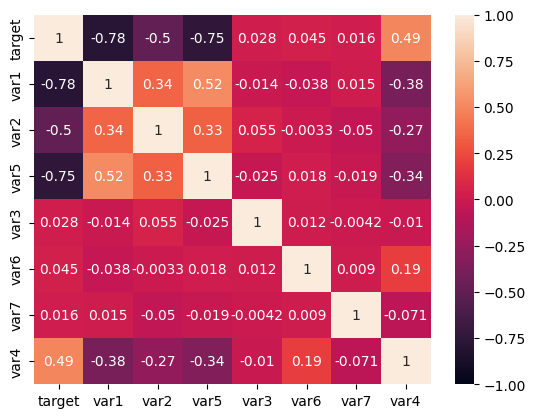

In [14]:
from scipy.stats import spearmanr
import seaborn as sns

correlation = preprocessed_data.corr(method="spearman")
heatmap = sns.heatmap(preprocessed_data.corr(), vmin=-1, 
                      vmax=1, annot=True)

## Implementing the PCA

### Data scaling

As we discussed on labs - PCA is sensitive to scaling. Therefore, I scale data using StandardScaler.

In [15]:
from sklearn.preprocessing import StandardScaler

# Scale data for PCA
standard_scaler = StandardScaler()
scaled_data = standard_scaler.fit_transform(preprocessed_data)
scaled_data = pd.DataFrame(scaled_data, 
                           columns=preprocessed_data.columns)

### PCA

In [16]:
# My PCA class
class PCA:
    dim : int
    good_eig_v : np.ndarray
    exp_var : list


    # Dim in this case can represent dimension or expected variance (As it works in sklearn)
    def __init__(self, dim):
        if type(dim) == int and dim < 1:
            raise Exception('Given dimension is less than 1')
        if type(dim) == float and (0 > dim or dim > 1):
            raise Exception('Given % of variance is incorrect')
        self.dim = dim


    # Function to fit given data and calculate best eigenvectors for use
    def fit(self, to_pca_data, plot_eginvalues=False, print_eigenvectors=False):
        # Calculate covariance
        cov = np.cov(to_pca_data.T)

        # Get eigenvalues and eigenvectors
        w, v = np.linalg.eig(cov)

        if self.dim > len(v):
            raise Exception('Given dimension is more than initial dimension')

        if plot_eginvalues:
            plt.bar([i+1 for i in range(len(w))], w)
            plt.title("Eigenvalues")
            plt.xlabel("Magnitude of the eigenvalue")
            plt.show()

        column_names = [f'v{i+1}' for i in range(len(v))]

        # Represent eigenvectors as dataframe
        v = pd.DataFrame(v, columns=column_names)
        if print_eigenvectors:
            print(v)

        total_egnvalues = sum(w)
        self.exp_var = [(i/total_egnvalues) for i in sorted(w, reverse=True)]
        
        sorted_names = [i for _, i in sorted(zip(w, column_names), reverse=True)]
        if type(self.dim) == int:
            self.good_eig_v = v[sorted_names[:self.dim]].values
            self.exp_var = self.exp_var[:self.dim]
        else:
            cum_sum = np.cumsum(self.exp_var)
            for i in range(len(cum_sum)):
                if cum_sum[i] > self.dim:
                    self.good_eig_v = v[sorted_names[:i+1]].values
                    self.exp_var = self.exp_var[:i+1]
                    break

        return self


    # Function that transforms given data using good eigenvectors
    def transform(self, to_pca_data):
        if type(to_pca_data) == pd.core.frame.DataFrame:
            return np.dot(to_pca_data.values, self.good_eig_v)
        else:
            return np.dot(to_pca_data, self.good_eig_v)


    # Function that returns Explained variance
    def explained_variance_ratio(self):
        return self.exp_var

According to eigenvalues - we need to take the first and the sixth eigenvectors to get the best result

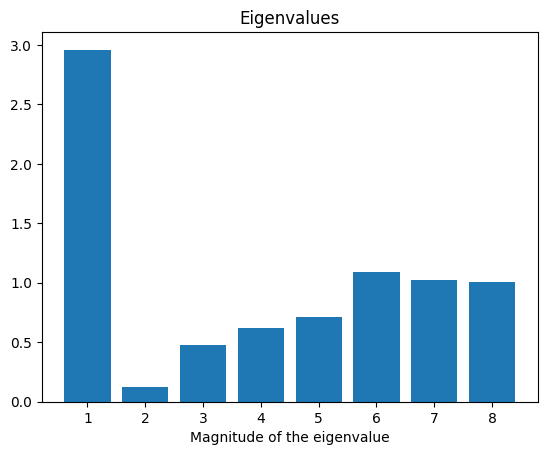

['target' 'var1' 'var2' 'var5' 'var3' 'var6' 'var7' 'var4']



In [17]:
# Initialize my PCA object and fit it
pca = PCA(2)
pca.fit(scaled_data, plot_eginvalues=True)

# Print column names
print(scaled_data.columns.values, end='\n\n')

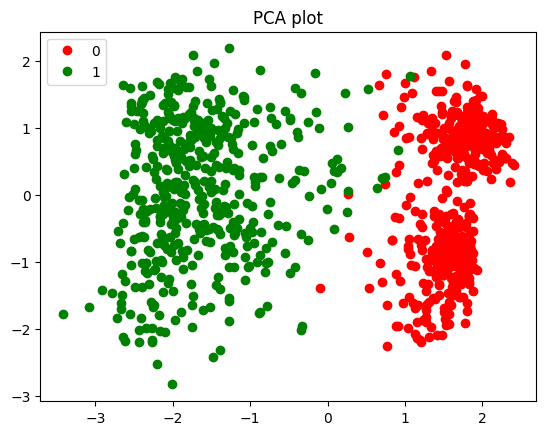

In [18]:
# Use eigenvectors with the highest eigenvalues for pca
x_pca = pca.transform(scaled_data)

# Prepare data for ploting
color = ['r', 'g']
label = [0, 1]
to_plot = pd.DataFrame(x_pca, columns=['x', 'y'])
to_plot = pd.concat([preprocessed_data.loc[:, :'target'], to_plot], axis=1)

# Plot data
for i in range(len(label)):
    x_y_temp = to_plot.loc[to_plot['target']==label[i], 'x':'y']
    x_temp = x_y_temp['x']
    y_temp = x_y_temp['y']
    c = color[i]
    l = label[i]
    plt.plot(x_temp, y_temp, 'o', c=c, label=str(l))

# Show plot
plt.legend()
plt.title("PCA plot")
plt.show()

# Training

### Split and scale preprocessed data

Firstly, we need to split preprocessed data on training and testing

In [19]:
# Split data to target and features
X = preprocessed_data.iloc[:, 1:]
y = preprocessed_data['target']

# Split data to training and testing
random_state = 13
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=random_state, 
                                                    shuffle=True)

And scale it

In [20]:
# Scale testing and training data
scaler = StandardScaler()
scaler.fit(X_train)

# Create Data Frames with scaled data
X_train = pd.DataFrame(scaler.transform(X_train), 
                       columns=X_train.columns)

X_test = pd.DataFrame(scaler.transform(X_test), 
                      columns=X_test.columns)

## Without PCA

### Logistic Regression

#### Check perfomance using cross validation on training set

In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Create Logistic Regression model and check it through KFold Cross-Validation 
logistic_reg = LogisticRegression(random_state=0)
scores = cross_val_score(logistic_reg, X_train, y_train,
                         cv=3, scoring='accuracy')
avg_score = np.mean(scores)
print('Cross-Validation score is:', avg_score)

Cross-Validation score is: 0.9581207552966218


#### Check perfomance on testing set

In [22]:
# Fit model on training set
logistic_reg.fit(X_train, y_train)

# Check perfomance on testing set
y_pred = logistic_reg.predict(X_test)

print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred)))

Testing accuracy = 0.9837837837837838


### KNN

#### Check perfomance using cross validation on training set

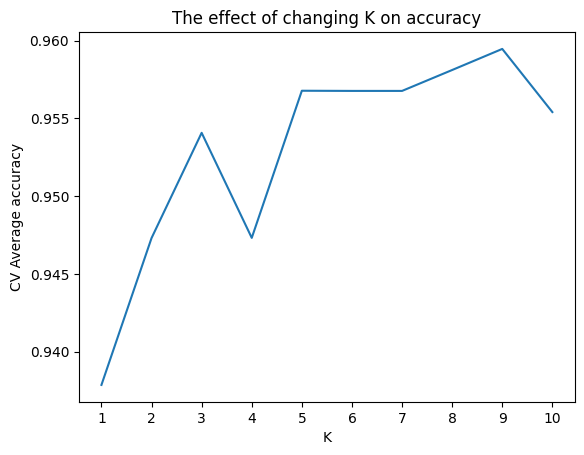

Best K: 9
Best Cross-Validation Score: 0.9594647970771205


In [23]:
from sklearn.neighbors import KNeighborsClassifier

# Create data for testing hyperparameters
neighbors = list(range(1, 11))
cv_scores = []

# Create KNN model and check it through KFold Cross-Validation on different number of neighbors
for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    scores = cross_val_score(knn, X_train, y_train,
                             cv=3, scoring='accuracy')
    avg_score = np.mean(scores)
    cv_scores.append(avg_score)

# Plot average accurancy on different number of neighbors
plt.title('The effect of changing K on accuracy')
plt.plot(neighbors, cv_scores)
plt.xlabel('K')
plt.xticks(neighbors)
plt.ylabel('CV Average accuracy')
plt.show()
print('Best K:', neighbors[np.argmax(cv_scores)])
print('Best Cross-Validation Score:', cv_scores[np.argmax(cv_scores)])

#### Check perfomance on testing set

In [24]:
# Fit model on training set with the best number of neighbours
knn = KNeighborsClassifier(n_neighbors=neighbors[np.argmax(cv_scores)])
knn.fit(X_train, y_train)

# Check perfomance on testing set
y_pred = knn.predict(X_test)

print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred)))

Testing accuracy = 0.9783783783783784


### Naive Bayes

#### Check perfomance using cross validation on training set

In [25]:
from sklearn.naive_bayes import GaussianNB

# Create Naive Bayes model and check it through KFold Cross-Validation 
gauss_nb = GaussianNB()
scores = cross_val_score(gauss_nb, X_train, y_train,
                         cv=3, scoring='accuracy')
avg_score = np.mean(scores)
print('Cross-Validation score is:', avg_score)

Cross-Validation score is: 0.95273361640499


#### Check perfomance on testing set

In [26]:
# Fit model on training set
gauss_nb.fit(X_train, y_train)

# Check perfomance on testing set
y_pred = gauss_nb.predict(X_test)

print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred)))

Testing accuracy = 0.9837837837837838


## With PCA

### Scale data for PCA and fit it

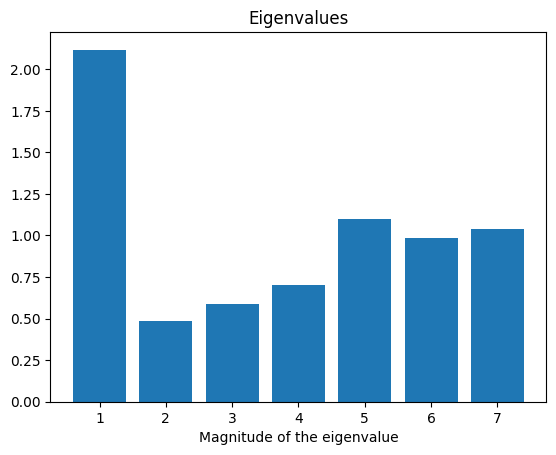

['var1' 'var2' 'var5' 'var3' 'var6' 'var7' 'var4']

Cumulative Variances (Percentage):
[0.30207489 0.45873262 0.60658252 0.74674088 0.8467588 ]


In [27]:
# Number of components of PCA
components = 0.8

# Prepare PCA data
pca = PCA(components)
pca.fit(X_train, plot_eginvalues=True)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Print column names
print(X_train.columns.values, end='\n\n')

# Cumulative Variances
print("Cumulative Variances (Percentage):")
print(np.cumsum(pca.explained_variance_ratio()))

### Logistic Regression

#### Check perfomance using cross validation on training set

In [28]:
# Create Logistic Regression model and check it through KFold Cross-Validation 
logistic_reg = LogisticRegression(random_state=0)
scores = cross_val_score(logistic_reg, X_train_pca, y_train,
                         cv=3, scoring='accuracy')
avg_score = np.mean(scores)
print('Cross-Validation score is:', avg_score)

Cross-Validation score is: 0.9540666864158519


#### Check perfomance on testing set

In [29]:
# Fit model on training set
logistic_reg.fit(X_train_pca, y_train)

# Check perfomance on testing set
y_pred = logistic_reg.predict(X_test_pca)

print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred)))

Testing accuracy = 0.9675675675675676


### KNN

#### Check perfomance using cross validation on training set

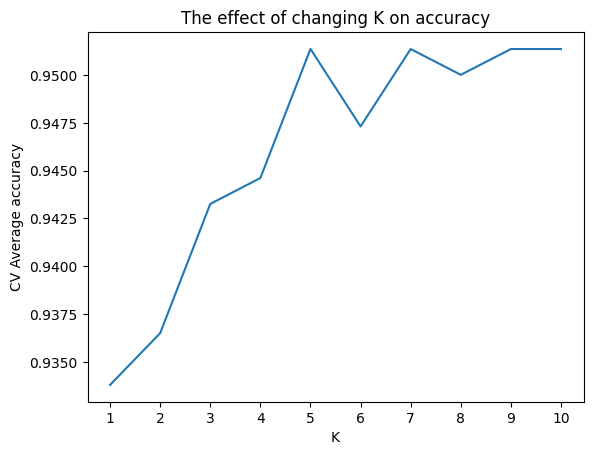

Best K: 5
Best Cross-Validation Score: 0.9513676310852177


In [30]:
# Create data for testing hyperparameters
neighbors = list(range(1, 11))
cv_scores = []

# Create KNN model and check it through KFold Cross-Validation on different number of neighbors
for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    scores = cross_val_score(knn, X_train_pca, y_train,
                             cv=3, scoring='accuracy')
    avg_score = np.mean(scores)
    cv_scores.append(avg_score)

# Plot average accurancy on different number of neighbors
plt.title('The effect of changing K on accuracy')
plt.plot(neighbors, cv_scores)
plt.xlabel('K')
plt.xticks(neighbors)
plt.ylabel('CV Average accuracy')
plt.show()
print('Best K:', neighbors[np.argmax(cv_scores)])
print('Best Cross-Validation Score:', cv_scores[np.argmax(cv_scores)])

#### Check perfomance on testing set

In [31]:
# Fit model on training set with the best number of neighbours
knn = KNeighborsClassifier(n_neighbors=neighbors[np.argmax(cv_scores)])
knn.fit(X_train_pca, y_train)

# Check perfomance on testing set
y_pred = knn.predict(X_test_pca)

print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred)))

Testing accuracy = 0.9891891891891892


### Naive Bayes

#### Check perfomance using cross validation on training set

In [32]:
# Create Naive Bayes model and check it through KFold Cross-Validation 
gauss_nb = GaussianNB()
scores = cross_val_score(gauss_nb, X_train, y_train,
                         cv=3, scoring='accuracy')
avg_score = np.mean(scores)
print('Cross-Validation score is:', avg_score)

Cross-Validation score is: 0.95273361640499


#### Check perfomance on testing set

In [33]:
# Fit model on training set
gauss_nb.fit(X_train, y_train)

# Check perfomance on testing set
y_pred = gauss_nb.predict(X_test)

print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred)))

Testing accuracy = 0.9837837837837838


# References


I plot graphs in such way as it was represented in labs.

I used formulas and slides of lecture 5 to implement PCA. Moreover, I tried to implement my functions of PCA with the same names as in sklearn library.